# Health Insurance Premium Regression: Exploratory Data Analysis and Hypothesis Testing

In [1]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, binom, geom, t, ttest_ind, f_oneway, chi2_contingency, shapiro, spearmanr
import math
from itertools import combinations

RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
BLUE = "\033[34m"
RESET = "\033[0m"  # Resets to default color

sns.set_theme(style="darkgrid",palette="Pastel2")
%config InlineBackend.figure_format = 'svg'

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0   45         0                      0               0                   0   
1   60         1                      0               0                   0   
2   36         1                      1               0                   0   
3   52         1                      1               0                   1   
4   38         0                      0               0                   1   

   Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0     155      57               0                        0   
1     180      73               0                        0   
2     158      59               0                        0   
3     183      93               0                        0   
4     166      88               0                        0   

   NumberOfMajorSurgeries  PremiumPrice  
0                       0         25000  
1                       0         29000  
2                       1         23000  
3                       2         28000  
4                       1         23000

In [3]:
print('-'*80)
print(f'Shape of Data : {df.shape}')
print('-'*80)
print(f'Data Types : \n\n{df.dtypes}')
print('-'*80)
print(f'Count of Null values: \n\n{df.isnull().sum()}')
print('-'*80)
print(f'Count of duplicate rows: {df.duplicated().sum()}')
print('-'*80)
unique_values = {column: df[column].unique() for column in df.columns}
print(f'Unique Values : \n')
pprint.pprint(unique_values)
print('-'*80)


--------------------------------------------------------------------------------
Shape of Data : (986, 11)
--------------------------------------------------------------------------------
Data Types : 

Age                        int64
Diabetes                   int64
BloodPressureProblems      int64
AnyTransplants             int64
AnyChronicDiseases         int64
Height                     int64
Weight                     int64
KnownAllergies             int64
HistoryOfCancerInFamily    int64
NumberOfMajorSurgeries     int64
PremiumPrice               int64
dtype: object
--------------------------------------------------------------------------------
Count of Null values: 

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice             

In [4]:
# Converting categorical column to category type
cat_columns = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
df[cat_columns] = df[cat_columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      986 non-null    int64   
 1   Diabetes                 986 non-null    category
 2   BloodPressureProblems    986 non-null    category
 3   AnyTransplants           986 non-null    category
 4   AnyChronicDiseases       986 non-null    category
 5   Height                   986 non-null    int64   
 6   Weight                   986 non-null    int64   
 7   KnownAllergies           986 non-null    category
 8   HistoryOfCancerInFamily  986 non-null    category
 9   NumberOfMajorSurgeries   986 non-null    category
 10  PremiumPrice             986 non-null    int64   
dtypes: category(7), int64(4)
memory usage: 38.6 KB


In [5]:
df.describe()

Age      Height      Weight  PremiumPrice
count  986.000000  986.000000  986.000000    986.000000
mean    41.745436  168.182556   76.950304  24336.713996
std     13.963371   10.098155   14.265096   6248.184382
min     18.000000  145.000000   51.000000  15000.000000
25%     30.000000  161.000000   67.000000  21000.000000
50%     42.000000  168.000000   75.000000  23000.000000
75%     53.000000  176.000000   87.000000  28000.000000
max     66.000000  188.000000  132.000000  40000.000000

#### Insights

**1. Data Shape and Structure**

- Rows: 986
- Columns: 11, consisting of both predictor variables and a target variable (PremiumPrice).
- Target Variable: PremiumPrice (likely to be continuous since this is a regression problem).

**2. Data Types**

- All columns are currently of int64 type, which includes both categorical (binary and ordinal) and numerical features.
- Categorical variables like Diabetes, BloodPressureProblems, etc., are encoded as integers (0 and 1).
- It may be helpful to convert categorical features to a categorical data type if needed for certain modeling techniques.

**3. Missing and Duplicate Values**

- No Null Values: The dataset is complete, so no imputation or handling of missing data is necessary.
- No Duplicates: All rows are unique, which is beneficial as duplicate rows could bias the model.

**4. Unique Values per Feature**

- Age: Ranges from 18 to 66, indicating a middle-aged to senior demographic. This is typical for insurance-related datasets.
- Binary Categorical Columns: Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, HistoryOfCancerInFamily, and- - - KnownAllergies are binary (0 or 1), which makes them easy to interpret and model as dummy variables.
- Height and Weight: Distributed across a range of values, with Height from 145 to 188 cm and Weight from 51 to 132 kg. It maybe worth calculating BMI from these two features, as it might correlate better with PremiumPrice than using them separately.
- Number of Major Surgeries: Includes small values (0, 1, 2, 3), representing the number of surgeries, which might contributeto higher insurance premiums.
- PremiumPrice: Ranges from 15,000 to 40,000, showing variability, which is essential for training a regression model.

**5. Potential Feature Engineering**

- BMI: Adding BMI as a derived feature from Height and Weight could provide a more nuanced health-related feature.
- Age Groups: Consider creating age groups (e.g., 18–25, 26–35, etc.) to capture patterns across age ranges.
- Interaction Terms: You might explore interactions between health-related features (e.g., Diabetes and BloodPressureProblems), as combinations of conditions could impact premiums.

**6. Distribution of PremiumPrice**

- The range from 15,000 to 40,000 for PremiumPrice suggests a relatively wide distribution. Checking its distribution (e.g., histogram) could reveal skewness or outliers, which would influence the model’s performance and the choice of evaluation metrics.

In [6]:
# Creating the BMI column
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

In [7]:
# Creating Age group categorical variable
df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 25, 35, 50, 70], labels=[1, 2, 3, 4])

In [8]:
numeric_columns = ['Age', 'Height', 'Weight', 'BMI']
categorical_columns = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'AgeGroup']
target_column = 'PremiumPrice'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      986 non-null    int64   
 1   Diabetes                 986 non-null    category
 2   BloodPressureProblems    986 non-null    category
 3   AnyTransplants           986 non-null    category
 4   AnyChronicDiseases       986 non-null    category
 5   Height                   986 non-null    int64   
 6   Weight                   986 non-null    int64   
 7   KnownAllergies           986 non-null    category
 8   HistoryOfCancerInFamily  986 non-null    category
 9   NumberOfMajorSurgeries   986 non-null    category
 10  PremiumPrice             986 non-null    int64   
 11  BMI                      986 non-null    float64 
 12  AgeGroup                 986 non-null    category
dtypes: category(8), float64(1), int64(4)
memory usage: 47.5 KB


## Visual analysis

### Univariate Analysis

In [9]:
def univariate_graphs(df, columns, type):
    rows = (len(columns) + 1) // 2
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    index = 0
    for row in range(rows):
        for col in range(cols):
            if( type == 'num'):
                sns.histplot(df[columns[index]], kde=True, ax=axs[row,col])
            elif( type == 'cat'):
                sns.countplot(x=columns[index], data=df, ax=axs[row, col], alpha=0.8)
            else:
                print('Invalid type')
                break
            index += 1
            if (index>=len(columns)):
                break
        if (index>=len(columns)):
            break
    if(len(columns)%2==1):
      axs.flat[-1].set_visible(False)
    plt.tight_layout()
    plt.show()

def bivariate_graphs(df, columns, target, type):
    rows = (len(columns) + 1) // 2
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    index = 0
    for row in range(rows):
        for col in range(cols):
            if( type == 'num'):
                sns.scatterplot(x=columns[index], y=target, data=df, ax=axs[row,col])
            elif( type == 'cat'):
                sns.boxplot(x=columns[index], y=target, data=df, ax=axs[row,col])
            else:
                print('Invalid type')
                break
            index += 1
            if (index>=len(columns)):
                break
        if (index>=len(columns)):
            break
    if(len(columns)%2==1):
      axs.flat[-1].set_visible(False)
    plt.tight_layout()
    plt.show()

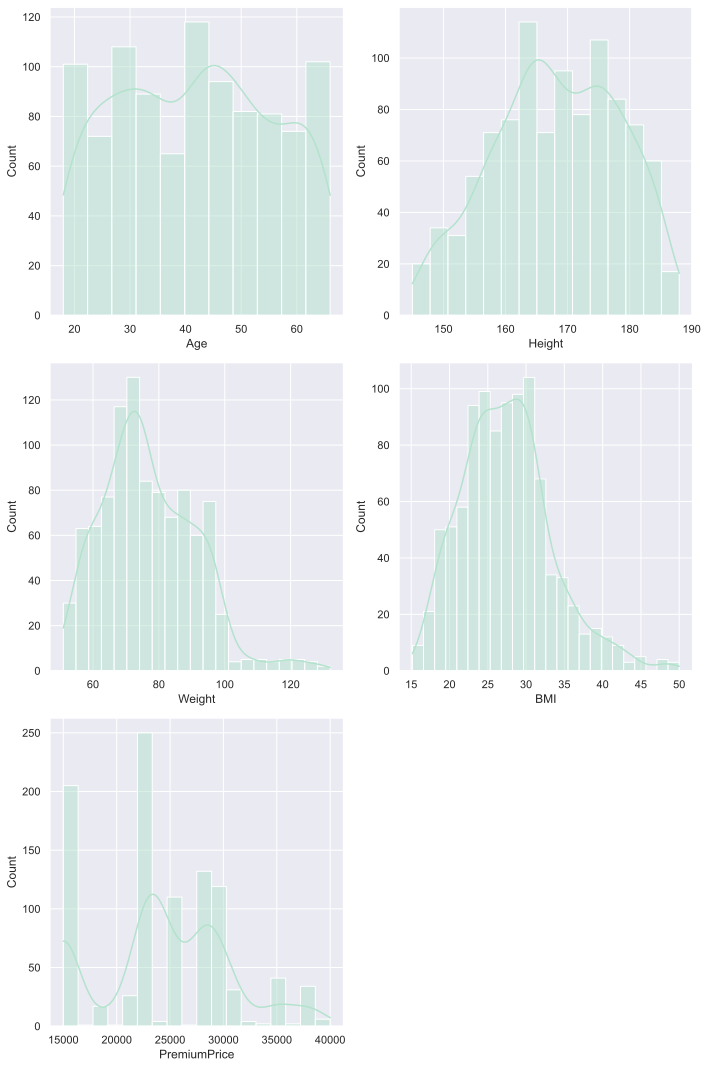

In [10]:
univariate_graphs(df, numeric_columns + [target_column], "num")

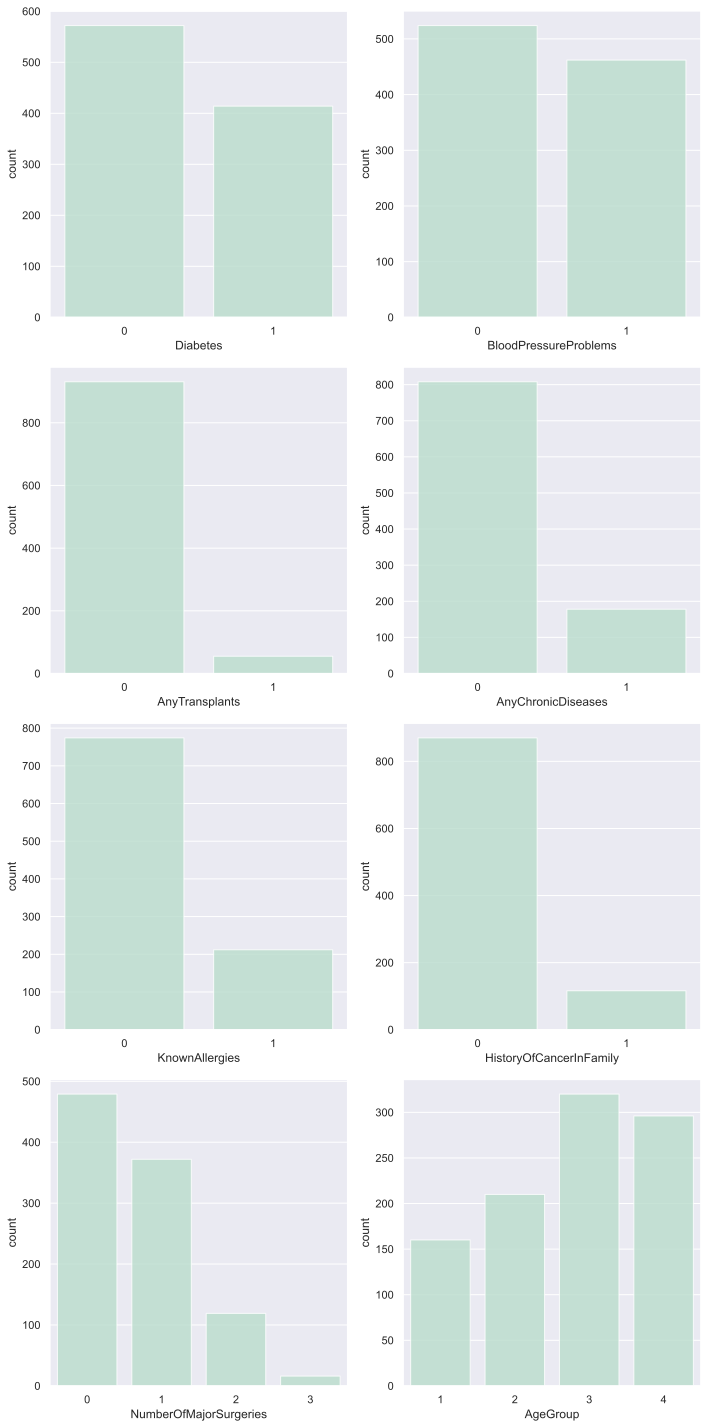

In [11]:
univariate_graphs(df, categorical_columns, "cat")

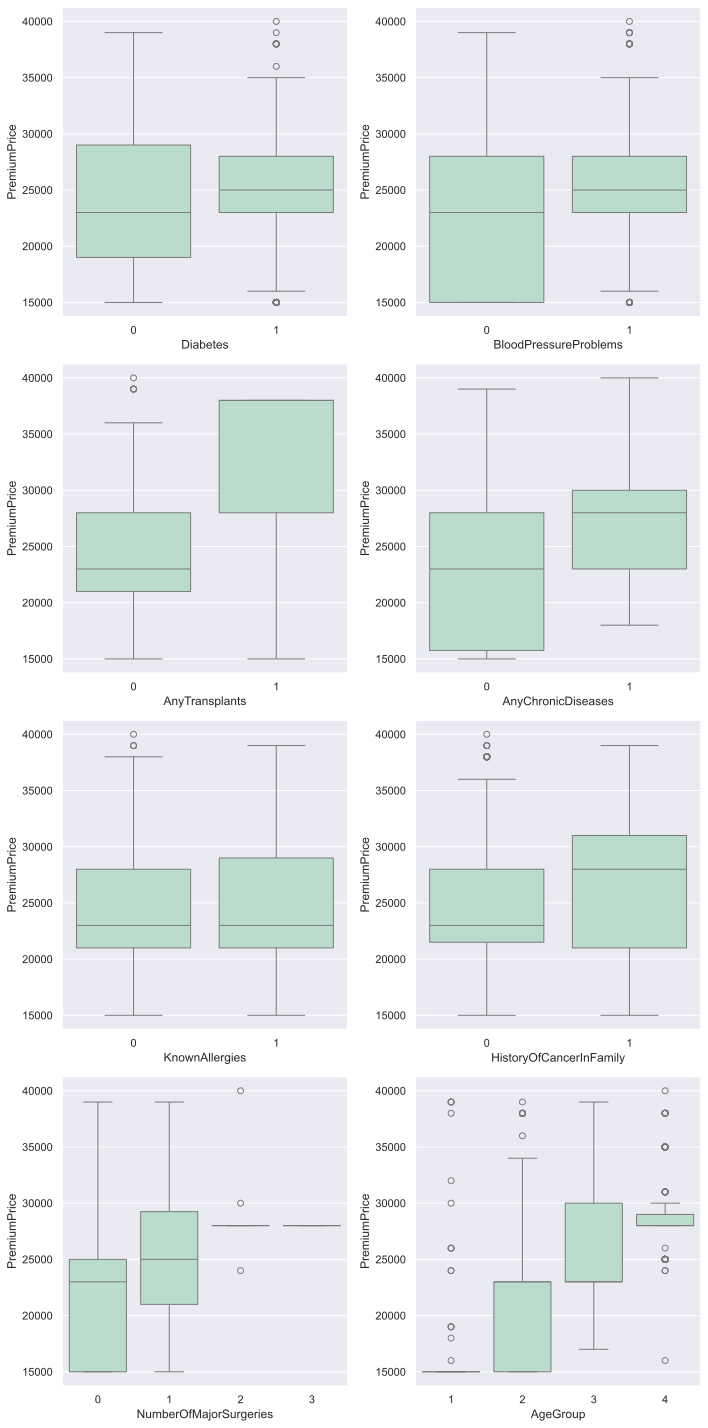

In [12]:
bivariate_graphs(df, categorical_columns, target_column, "cat")

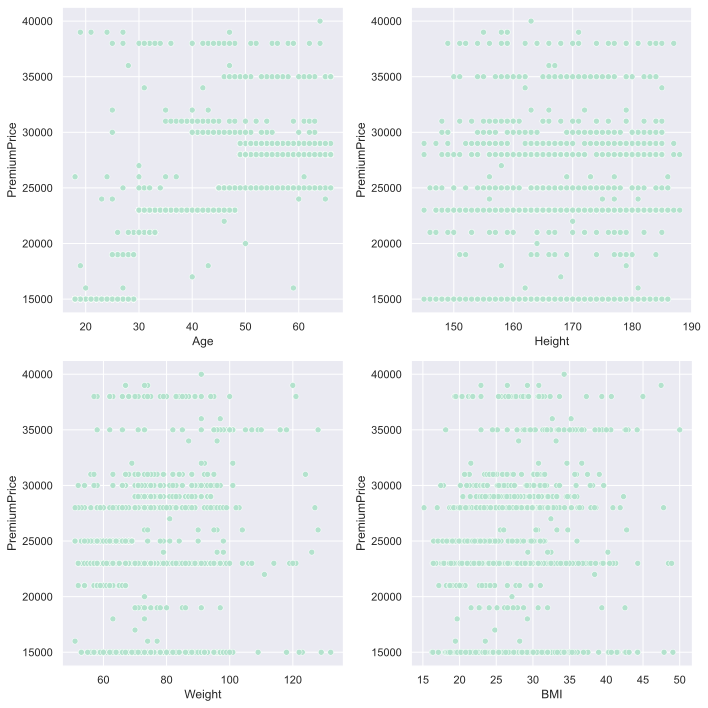

In [13]:
bivariate_graphs(df, numeric_columns, target_column, "num")

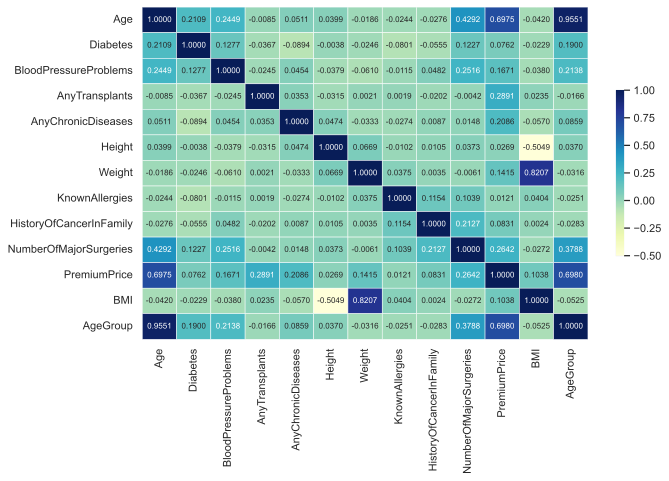

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".4f", annot_kws={"size": 8},  # Reduce font size
            square=False, cmap='YlGnBu', linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.show()

In [15]:
sns.pairplot(df[numeric_columns + [target_column]], kind='scatter', diag_kind='kde', height=1.9, plot_kws={'s': 15})
plt.show()

In [16]:
def check_normality_multiple(df, numerical_columns, n_columns=2):
    shapiro_results = {}
    n_plots = len(numerical_columns)
    n_rows = math.ceil(n_plots / n_columns)
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 5 * n_rows))
    axes = axes.flatten()  

    for i, column in enumerate(numerical_columns):
        stats.probplot(df[column], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot for {column}')
        _, shapiro_p_value = shapiro(df[column])
        shapiro_results[column] = shapiro_p_value

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    print("\nShapiro-Wilk Test Results:")
    for column, p_value in shapiro_results.items():
        if p_value <= 0.05:
            print(f'{RED}{column}: Not normally distributed (p-value = {p_value:.3f}){RESET}')
        else:
            print(f'{GREEN}{column}: Normally distributed (p-value = {p_value:.3f}){RESET}')



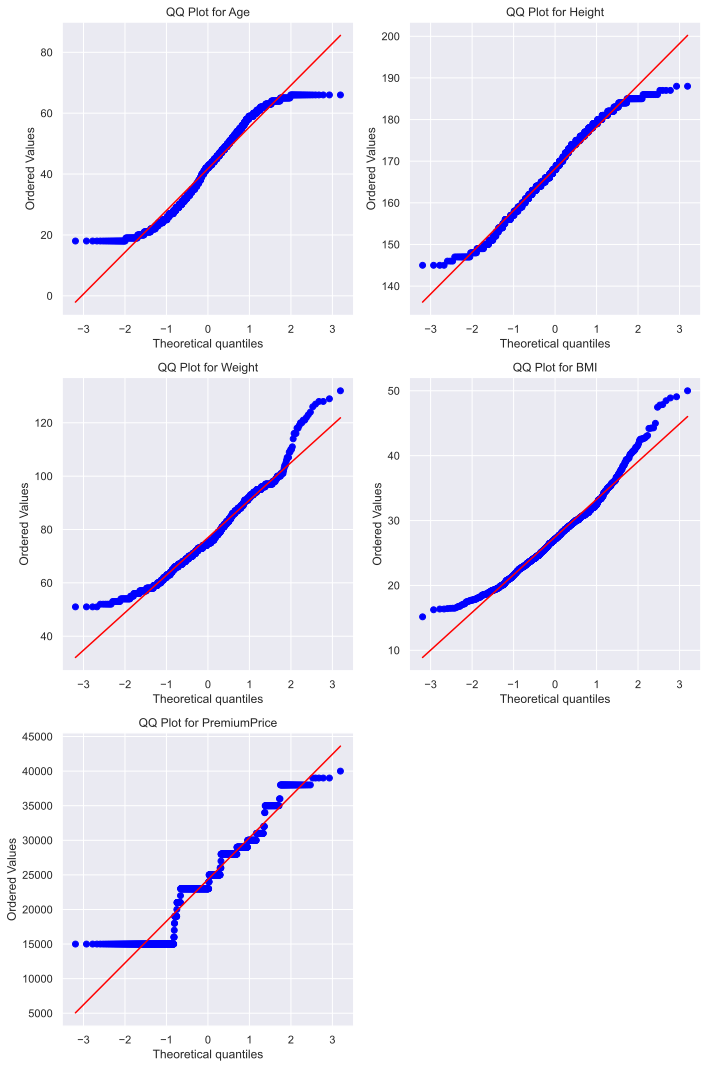


Shapiro-Wilk Test Results:
Age: Not normally distributed (p-value = 0.000)
Height: Not normally distributed (p-value = 0.000)
Weight: Not normally distributed (p-value = 0.000)
BMI: Not normally distributed (p-value = 0.000)
PremiumPrice: Not normally distributed (p-value = 0.000)


In [17]:
check_normality_multiple(df, numeric_columns+[target_column])

In [18]:
def t_test_ind(df, cat_col, num_col):
    categories = df[cat_col].unique()
    data = [df[df[cat_col] == category][num_col] for category in categories]
    # Perform t-test
    t_statistic, p_value = ttest_ind(data[0], data[1])
    if p_value <= 0.05:
        result = "affects"
        print(f'{GREEN}{cat_col:<25} {result:<25} {p_value}{RESET}')
    else:
        result = "doesn't affect"
        print(f'{RED}{cat_col:<25} {result:<25} {p_value}{RESET}')
def anova(df, cat_col, num_col):
    # Perform ANOVA test between a categorical and a numerical column
    categories = df[cat_col].unique()
    data = [df[df[cat_col] == category][num_col] for category in categories]
    # Perform ANOVA
    f_statistic, p_value = f_oneway(*data)
    if p_value <= 0.05:
        result = "affects"
        print(f'{GREEN}{cat_col:<25} {result:<25} {p_value}{RESET}')
    else:
        result = "doesn't affect"
        print(f'{GREEN}{cat_col:<25} {result:<25} {p_value}{RESET}')
def correlation(df, num_col1, num_col2):
    # Calculate Pearson correlation coefficient between two numerical columns
    correlation_coefficient, _ = spearmanr(df[num_col1], df[num_col2])
    if correlation_coefficient >= 0.2:
        result = "positive effect"
        print(f'{GREEN}{num_col1:<25} {result:<25} {correlation_coefficient}{RESET}')
    elif correlation_coefficient <= -0.2:
        result = "negative effect"
        print(f'{GREEN}{num_col1:<25} {result:<25} {correlation_coefficient}{RESET}')
    else:
        result = "no effect"
        print(f'{RED}{num_col1:<25} {result:<25} {correlation_coefficient}{RESET}')


def perform_chi_square_test(df, col1, col2):
    # Create a contingency table of observed frequencies
    observed = pd.crosstab(df[col1], df[col2])
    # Perform Chi-Square Test
    chi2_stat, p_value_chi2, dof, expected = chi2_contingency(observed)
    # Check if p-value is less than alpha to make a decision
    if p_value_chi2 < 0.05:
        result = "dependent"
        print(f"{GREEN}{col1:<25} {col2:<25} {result:<25} {p_value_chi2}{RESET}")
    else:
        result = "independent"
        print(f"{RED}{col1:<25} {col2:<25} {result:<25} {p_value_chi2}{RESET}")

In [19]:
binary_categories = ['AnyChronicDiseases', 'AnyTransplants', 'BloodPressureProblems', 'Diabetes', 'KnownAllergies', 'HistoryOfCancerInFamily']
multi_categories = ['AgeGroup', 'NumberOfMajorSurgeries']
categorical_columns = ['AnyChronicDiseases', 'AnyTransplants', 'BloodPressureProblems', 'Diabetes', 'KnownAllergies', 'HistoryOfCancerInFamily', 'AgeGroup', 'NumberOfMajorSurgeries']
numerical_columns = ['Age', 'BMI', 'Height', 'Weight']
# performing ttest ind for all categorical columns with 2 categories with count as target
print('-'*80)
print('T-Test Independent Samples Results:')
print(f"{'Categorical Variable':<25} {'Effect on PremiumPrice':<25} {'ttest_ind p-value':<25}")
print("-" * 80)
for col in binary_categories:
    t_test_ind(df, col, 'PremiumPrice')
print('-'*80)
print('ANOVA Results:')
print(f"{'Categorical Variable':<25} {'Effect on PremiumPrice':<25} {'anova p-value':<25}")
print("-" * 80)
# performing anova for all categorical columns with more than 2 categories with count as target
for col in multi_categories:
    anova(df, col, 'PremiumPrice')
print('-'*80)
print('Correlation Results:')
print(f"{'Numerical Variable':<25} {'Effect on PremiumPrice':<25} {'correlation coefficient':<25}")
print("-" * 80)
# performing correlation test for all numerical columns with count as target
for col in numerical_columns:
    correlation(df, col, 'PremiumPrice')
print('-'*80)
print('Chi Squared Test Results:')
# performing chisquared tests between categories
print(f"{'Categorical Variable 1':<25} {'Categorical Variable 2':<25} {'Dependency':<25} {'chi2 p_value':<25}")
print("-" * 80)
for col1, col2 in combinations(categorical_columns, 2):
    perform_chi_square_test(df, col1, col2)


--------------------------------------------------------------------------------
T-Test Independent Samples Results:
Categorical Variable      Effect on PremiumPrice    ttest_ind p-value        
--------------------------------------------------------------------------------
AnyChronicDiseases        affects                   3.713413765291482e-11
AnyTransplants            affects                   1.9787295423632772e-20
BloodPressureProblems     affects                   1.3100497090721932e-07
Diabetes                  affects                   0.016690091385306107
KnownAllergies            doesn't affect            0.7042667378180334
HistoryOfCancerInFamily   affects                   0.009005587310447026
--------------------------------------------------------------------------------
ANOVA Results:
Categorical Variable      Effect on PremiumPrice    anova p-value            
--------------------------------------------------------------------------------
AgeGroup                  af

### Key Insights

1. **Health Conditions**: Chronic diseases, transplants, blood pressure issues, diabetes, and cancer history significantly affect `PremiumPrice`, while allergies do not.

2. **Age & Surgeries**: Both age group and the number of major surgeries have a strong impact on `PremiumPrice`, suggesting these are key risk factors.

3. **Physical Metrics**: Height, weight, and BMI show little influence on `PremiumPrice`, so they may be less relevant for premium calculations.

4. **Interdependencies**: Certain health conditions, like diabetes and blood pressure issues, often co-occur, especially within specific age groups. This co-occurrence could affect premium rates for these groups. 

These insights highlight essential features for predictive modeling of insurance premiums.
